# Notebook 2: Modeling (Classification and Feature Selection)
This notebook:
- Reads the preprocessed data.
- Sets up classification tasks (binary or multi-class).
- Demonstrates MLPClassifier, RandomForestClassifier, KNN.
- Uses techniques like Lasso and RandomForest for feature selection.
- Optionally uses SMOTE to address class imbalance.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, GridSearchCV, 
    StratifiedKFold, LeaveOneOut
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    confusion_matrix, classification_report
)
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

# SMOTE
from imblearn.over_sampling import SMOTE

# (Optional) for interpretability
import shap
from time import time

## 1. Load Preprocessed Data
Make sure you reference the *cleaned* CSV from Notebook 1.

   event_id  victim_id victim_type victim_gender party1 general_category_1  \
0         1          1   Authority          Male    PRD        Alcalde(sa)   
1         2          2       Party        Female    PRI   Pre-candidato(a)   
2         3          3   Authority          Male    PRD     Funcionario(a)   
3         4          4   Authority          Male    PRI     Ex-Alcalde(sa)   
4         4          5   Authority          Male    PAN           Familiar   

  level_of_government          government_area event_type  \
0           Municipal                Executive     Murder   
1           Municipal  Elections and Campaigns     Murder   
2           Municipal                Executive     Murder   
3           Municipal                Executive     Murder   
4           Municipal                Executive     Murder   

             aggressor  ... Totalpopulation Female_population  \
0  Sujeto(s) armado(s)  ...         3540685           1840073   
1      No identificado  ...       

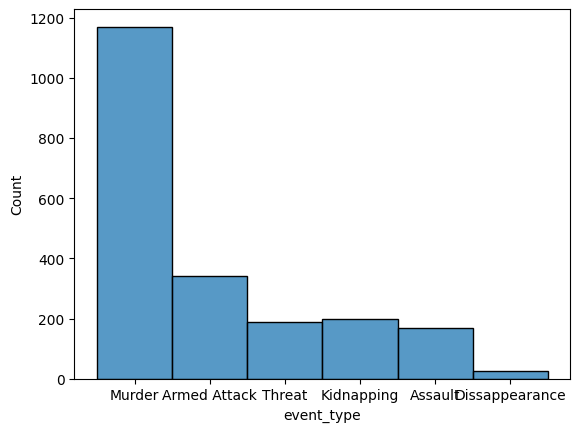

In [3]:
# Adjust path accordingly
database = pd.read_csv(r"D:\05.Laboral\08.Git and github\06.Political violence\Data\preprocessed_data.csv")
print(database.head())
database.describe()

# Quick histogram
sns.histplot(data=database, x="event_type")
plt.show()

## 2. Prepare the Data for Modeling
For example, you might drop certain columns again or do more transformations if needed.
Below is an adaptation of Code 3/4.

Missing Values:
 party1    42
dtype: int64


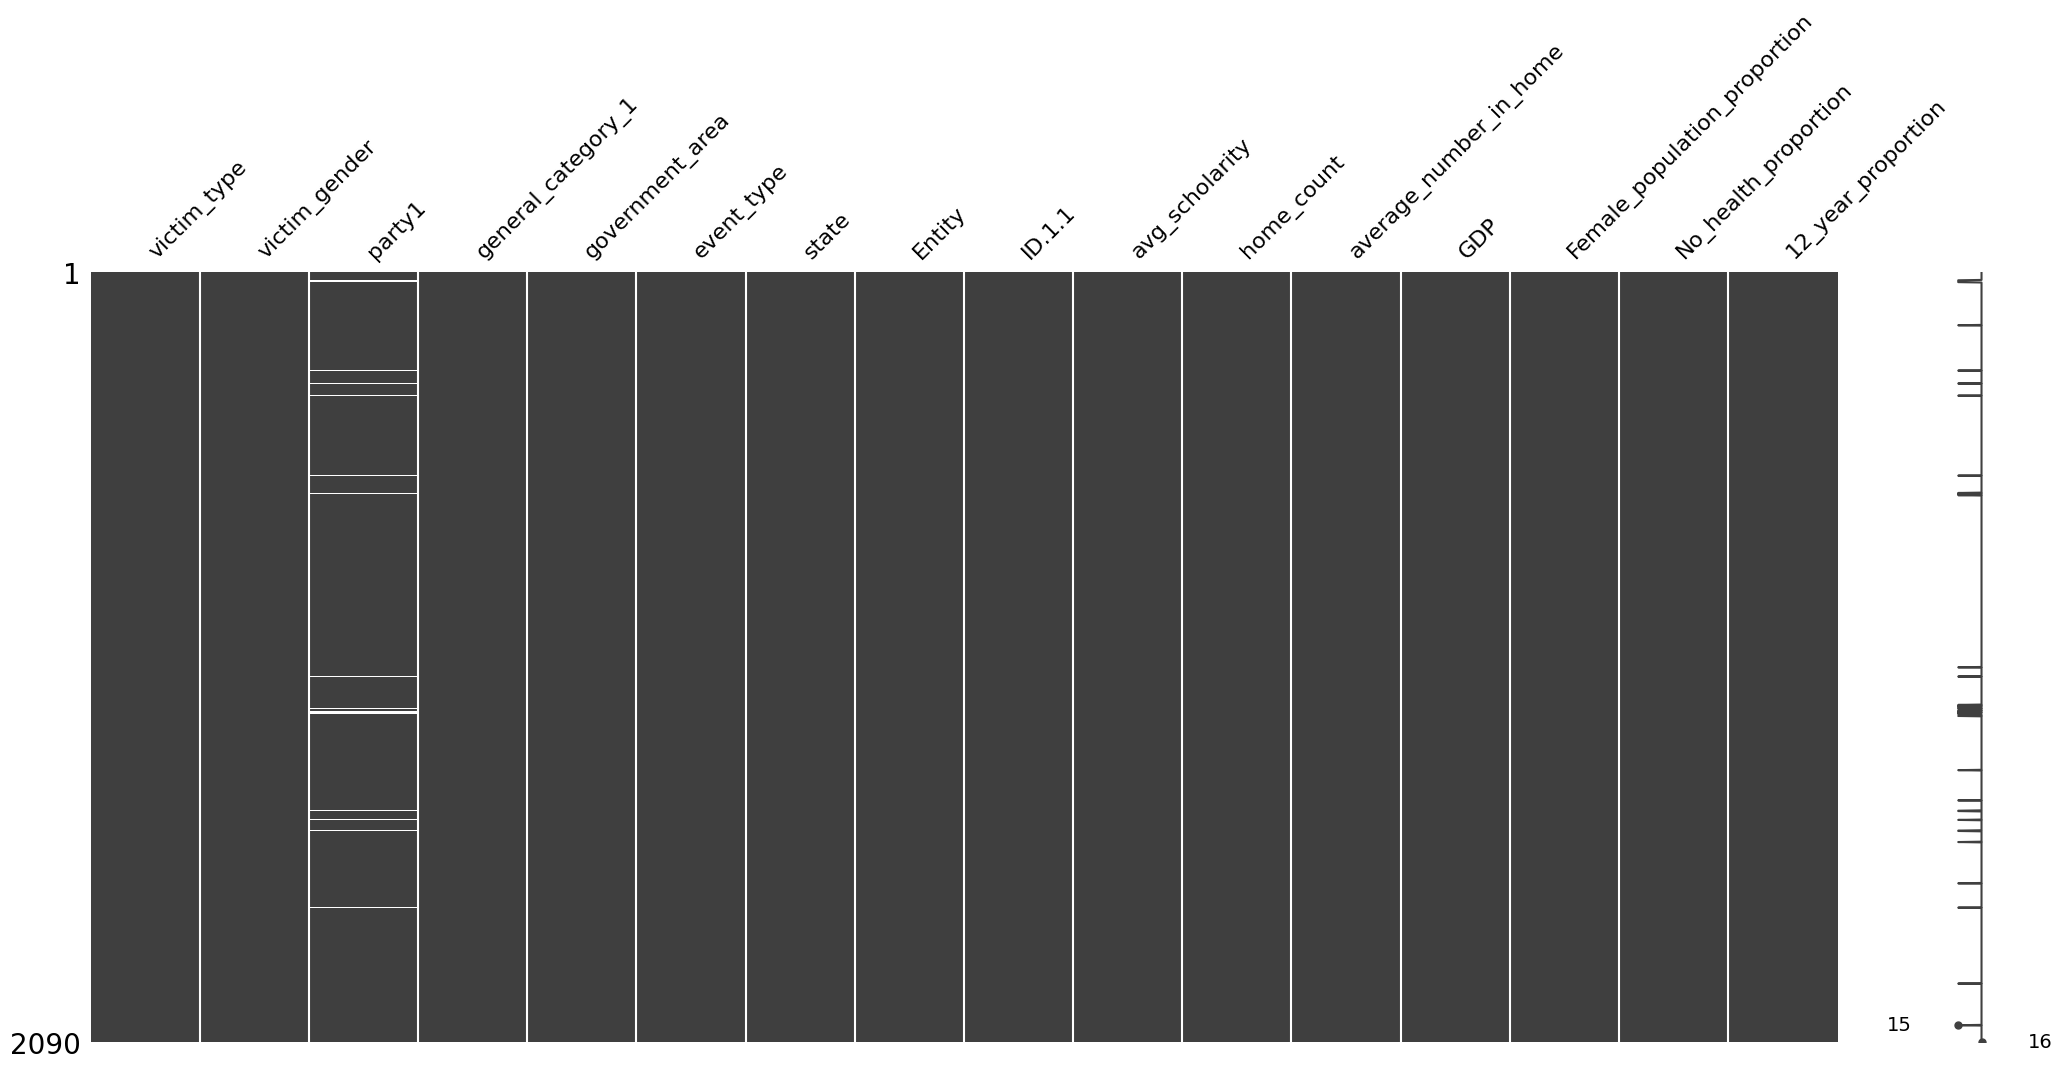


Event Type distribution before encoding:
 event_type
Murder            1170
Armed Attack       341
Kidnapping         198
Threat             187
Assault            167
Dissappearance      27
Name: count, dtype: int64


C:\Users\Artur\AppData\Local\Temp\ipykernel_13688\3640607372.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['party1'].fillna('Unknown', inplace=True)


In [4]:
# Example column drops:
data = database.drop(
    columns=[
        "Totalpopulation","ID.1", "ID", "event_id", "Number", "victim_id", "date",\
        "victim_name", "party2", "party3", "party4", "coallition", "1stpoliticaloffice",\
        "2ndpoliticaloffice", "3rdpoliticaloffice", "general_category_2", "general_category_3",\
        "remarks_on_the_crime", "Concepto", "INEGIcode", "MunINEGIcode", "aggressor",\
        "municipal", "level_of_government"
    ],
    errors='ignore'
)

# Create new proportion columns
data['Male_population_proportion']    = data['Male_population'] / (data['Male_population'] + data['Female_population'])
data['Female_population_proportion']  = data['Female_population'] / (data['Male_population'] + data['Female_population'])
data['No_health_proportion']         = data['No_health_services_pop'] / (data['Male_population'] + data['Female_population'])
data['12_year_proportion']           = data['12_year_old_single_population'] / (data['Male_population'] + data['Female_population'])

# Drop the now-redundant columns
data = data.drop(
    columns=[
        'Male_population','Female_population','economically_active_population',\
        'Male_population_proportion','No_health_services_pop','12_year_old_single_population'
    ],
    errors='ignore'
)

print("Missing Values:\n", data.isnull().sum()[data.isnull().sum() > 0])
msno.matrix(data)
plt.show()

# Fill missing GDP with median
data['GDP'] = data['GDP'].fillna(data['GDP'].median())

# Fill missing 'party1' with 'Unknown'
if 'party1' in data.columns:
    data['party1'].fillna('Unknown', inplace=True)

# Drop missing 'government_area' if needed
if 'government_area' in data.columns:
    data.dropna(subset=['government_area'], inplace=True)

print("\nEvent Type distribution before encoding:\n", data['event_type'].value_counts(dropna=False))

Missing Values:
 Series([], dtype: int64)


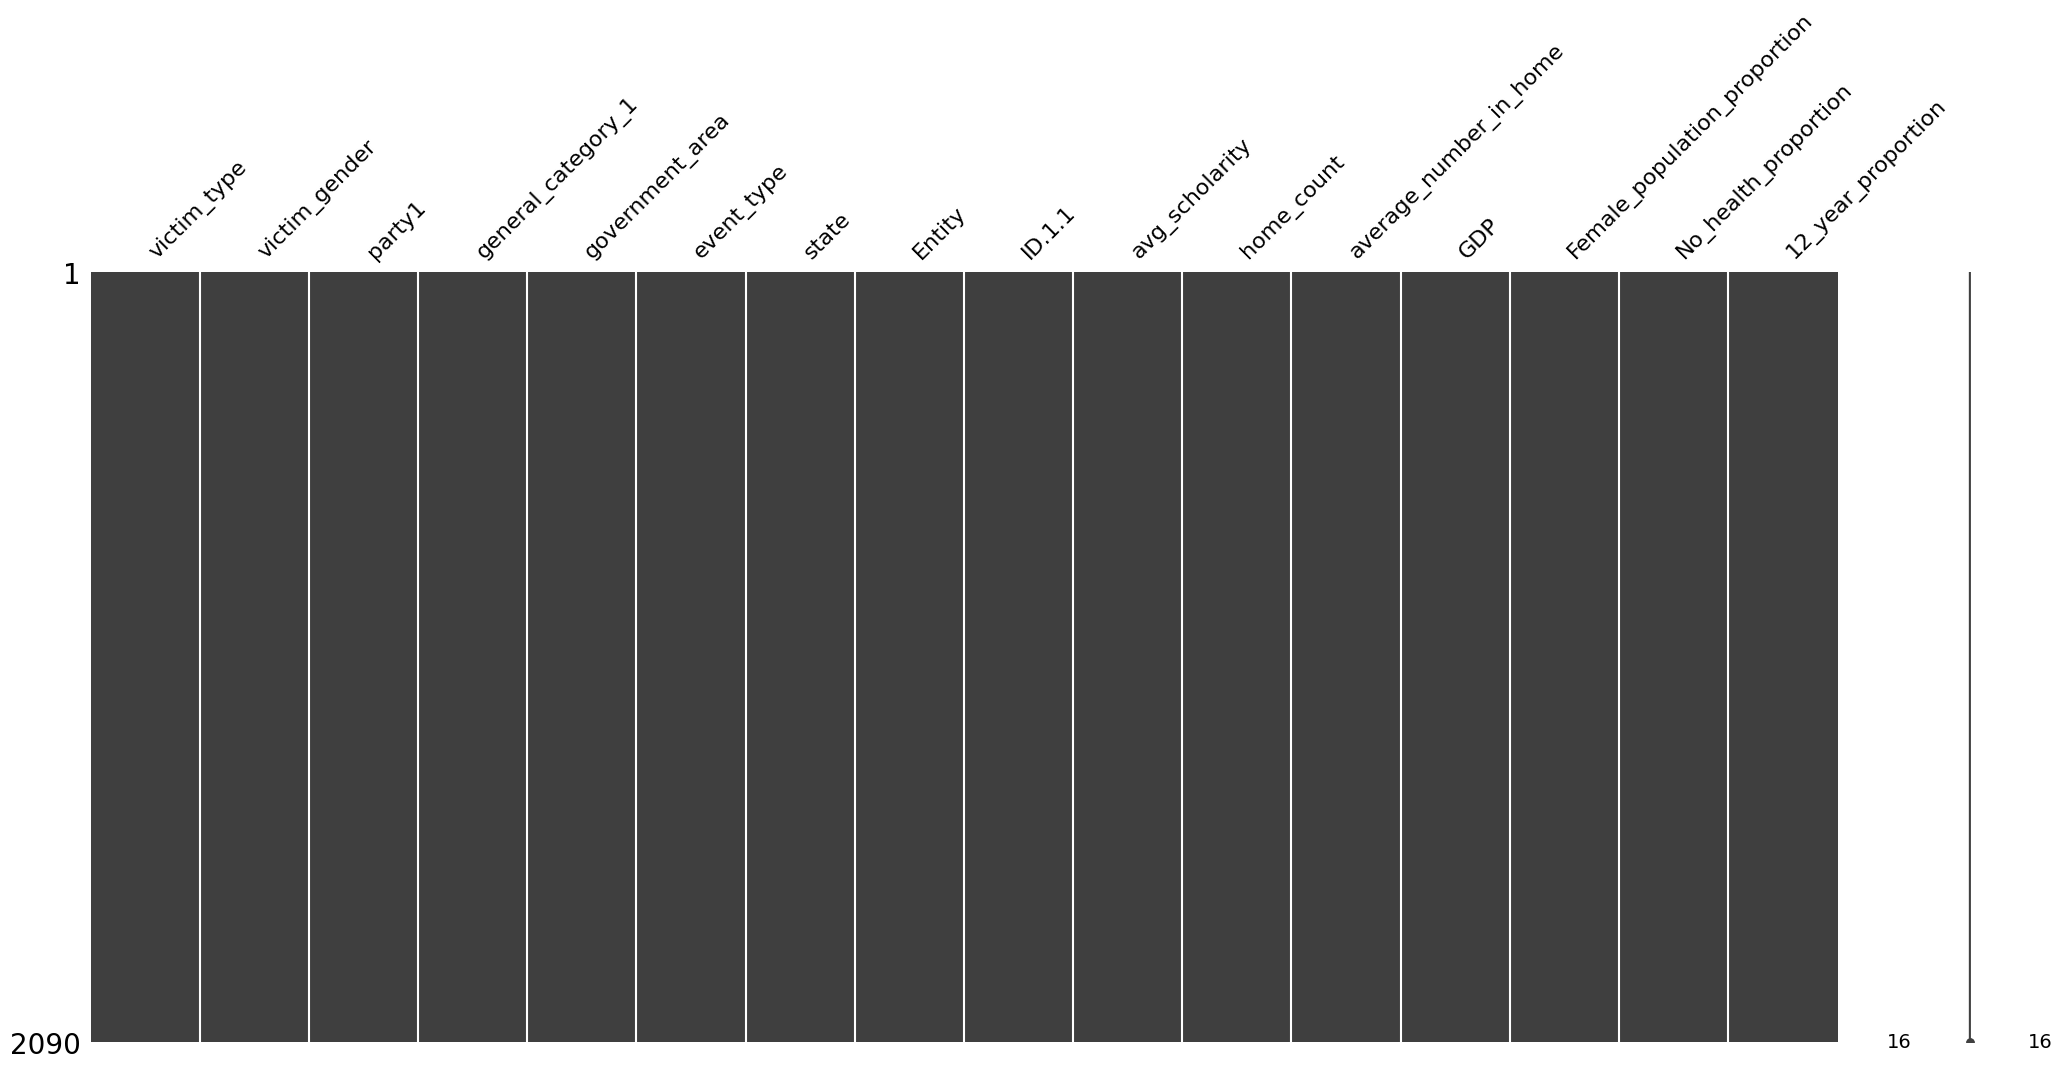

In [5]:
print("Missing Values:\n", data.isnull().sum()[data.isnull().sum() > 0])
msno.matrix(data)
plt.show()


## 3. Choose a Classification Strategy
We'll do multi-class classification (Code 4 approach).

In [6]:
# Label Encoding for 'event_type'
le = LabelEncoder()
data['event_type'] = le.fit_transform(data['event_type'])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Event Type Label Mapping:", label_mapping)

# Split data into X, y
X = data.drop(columns=['event_type'], errors='ignore')
X = pd.get_dummies(X, drop_first=True)
y = data['event_type']

Event Type Label Mapping: {'Armed Attack': 0, 'Assault': 1, 'Dissappearance': 2, 'Kidnapping': 3, 'Murder': 4, 'Threat': 5}


## 4. Handling Class Imbalance
Example: oversample non-"murder" classes (encoded as 4).

In [7]:
# SMOTE approach
murder_label = 4  # adapt if needed
murder_X = X[y == murder_label]
murder_y = y[y == murder_label]

non_murder_X = X[y != murder_label]
non_murder_y = y[y != murder_label]

#smote = SMOTE(sampling_strategy={label: 350 for label in non_murder_y.unique()}, random_state=42)
#smote = SMOTE(sampling_strategy=0.5, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)

non_murder_X_smote, non_murder_y_smote = smote.fit_resample(non_murder_X, non_murder_y)

X_combined = pd.concat([murder_X, non_murder_X_smote])
y_combined = pd.concat([murder_y, non_murder_y_smote])
combined_data = pd.concat([X_combined, y_combined], axis=1).sample(frac=1, random_state=42).reset_index(drop=True)

# Final data
data = combined_data
print("Final class distribution after SMOTE:\n", data['event_type'].value_counts())

# Redefine X, y
X = data.drop(columns=['event_type'])
y = data['event_type']

Final class distribution after SMOTE:
 event_type
4    1170
2     341
5     341
1     341
3     341
0     341
Name: count, dtype: int64


## 5. Train-Test Split or K-Fold
We use KFold in your code for demonstration. Typically, you might do `train_test_split`.


In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X_train = X
X_test = X
y_train = y
y_test = y

# Scaling
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_std  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## 6. Feature Selection
### 6.1 Lasso

In [9]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_std, y_train)
lasso_coefficients = lasso.coef_

selected_features_lasso = X_train.columns[lasso_coefficients != 0]
print("Selected features by LASSO:", selected_features_lasso.tolist())

Selected features by LASSO: ['Entity', 'ID.1.1', 'home_count', 'No_health_proportion', 'victim_type_Facility', 'victim_type_Party', 'party1_Chiapas Unido', 'party1_FPM', 'party1_Fernando Pérez Vega', 'party1_Futuro', 'party1_Hagamos', 'party1_INDEPENDIENTE', 'party1_INE', 'party1_MC', 'party1_MORENA', 'party1_Morelos Progresa', 'party1_Mover a Chiapas', 'party1_Movimiento de Unificación y Lucha Triqui (MULT)', 'party1_No disponible', 'party1_OTRO', 'party1_PAC', 'party1_PAN', 'party1_PANAL', 'party1_PES', 'party1_PRD', 'party1_PRI', 'party1_PSD', 'party1_PSI', 'party1_PVEM', 'party1_Pacto Social de Integración', 'party1_Partido Apoyo Social', 'party1_Partido Baja California (PBC)', 'party1_Partido Mujer', 'party1_Partido Popular Chiapaneco', 'party1_Partido Vida Nuevo León', 'party1_Partido del Bienestar', 'party1_Podemos Mover a Chiapas', 'party1_RSP', 'party1_RSS', 'party1_Todos por Veracruz', 'general_category_1_Candidato(a)', 'general_category_1_Colaborador(a)', 'general_category_1

### 6.2 Random Forest

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_std, y_train)
rf_importances = rf.feature_importances_

selected_features_rf = X_train.columns[rf_importances > 0]
print("\nSelected features by RF Feature Importances:", selected_features_rf.tolist())


Selected features by RF Feature Importances: ['Entity', 'ID.1.1', 'avg_scholarity', 'home_count', 'average_number_in_home', 'GDP', 'Female_population_proportion', 'No_health_proportion', '12_year_proportion', 'victim_type_Facility', 'victim_type_Party', 'victim_gender_Female', 'victim_gender_Male', 'party1_Chiapas Unido', 'party1_FPM', 'party1_Fernando Pérez Vega', 'party1_Futuro', 'party1_Hagamos', 'party1_INDEPENDIENTE', 'party1_INE', 'party1_MC', 'party1_MORELOS PROGRESA', 'party1_MORENA', 'party1_Morelos Progresa', 'party1_Mover a Chiapas', 'party1_Movimiento de Unificación y Lucha Triqui (MULT)', 'party1_No disponible', 'party1_OTRO', 'party1_PAC', 'party1_PAN', 'party1_PANAL', 'party1_PAS', 'party1_PES', 'party1_PRD', 'party1_PRI', 'party1_PSD', 'party1_PSI', 'party1_PT', 'party1_PVEM', 'party1_Pacto Social de Integración', 'party1_Partido Apoyo Social', 'party1_Partido Baja California (PBC)', 'party1_Partido Mujer', 'party1_Partido México Avanza', 'party1_Partido Popular Chiapa

## 7. Model Building and Evaluation

### 7.1 MLP with Lasso-Selected Features

In [11]:
X_train_lasso = X_train_std[selected_features_lasso]
X_test_lasso  = X_test_std[selected_features_lasso]

mlp_lasso = MLPClassifier(hidden_layer_sizes=(5,), max_iter=1000, random_state=0)
start_time = time()
mlp_lasso.fit(X_train_lasso, y_train)
train_time = time() - start_time

y_pred_lasso = mlp_lasso.predict(X_test_lasso)
acc_lasso    = accuracy_score(y_test, y_pred_lasso)
prec_lasso   = precision_score(y_test, y_pred_lasso, average='weighted')
rec_lasso    = recall_score(y_test, y_pred_lasso, average='weighted')

print("MLP with LASSO Selected Features:")
print(f"Accuracy: {acc_lasso:.4f}, Precision: {prec_lasso:.4f}, Recall: {rec_lasso:.4f}, Train Time: {train_time:.2f}s")

# Permutation Importance
res_lasso_perm = permutation_importance(mlp_lasso, X_test_lasso, y_test, n_repeats=10, random_state=0)
perm_imp_series = pd.Series(res_lasso_perm.importances_mean, index=X_test_lasso.columns)
top_10_features = perm_imp_series.sort_values(ascending=False).head(10)
print("\nTop 10 Feature Importances (MLP-LASSO):\n", top_10_features)

MLP with LASSO Selected Features:
Accuracy: 0.6591, Precision: 0.6377, Recall: 0.6591, Train Time: 5.38s

Top 10 Feature Importances (MLP-LASSO):
 party1_MORENA                            0.094609
general_category_1_Candidato(a)          0.088000
party1_PRI                               0.075130
victim_type_Facility                     0.062470
state_Jalisco                            0.057878
party1_PAN                               0.055200
state_Chiapas                            0.050957
state_Veracruz_de_Ignacio_de_la_Llave    0.039583
party1_MC                                0.038748
general_category_1_Funcionario(a)        0.035061
dtype: float64


### 7.2 MLP with Random Forest-Selected Features

In [12]:
X_train_rf = X_train_std[selected_features_rf]
X_test_rf  = X_test_std[selected_features_rf]

mlp_rf = MLPClassifier(hidden_layer_sizes=(5,), max_iter=1000, random_state=0)
start_time = time()
mlp_rf.fit(X_train_rf, y_train)
train_time = time() - start_time

y_pred_rf = mlp_rf.predict(X_test_rf)
acc_rf    = accuracy_score(y_test, y_pred_rf)
prec_rf   = precision_score(y_test, y_pred_rf, average='weighted')
rec_rf    = recall_score(y_test, y_pred_rf, average='weighted')

print("\nMLP with RF-Selected Features:")
print(f"Accuracy: {acc_rf:.4f}, Precision: {prec_rf:.4f}, Recall: {rec_rf:.4f}, Train Time: {train_time:.2f}s")

res_rf_perm = permutation_importance(mlp_rf, X_test_rf, y_test, n_repeats=10, random_state=0)
perm_imp_series_rf = pd.Series(res_rf_perm.importances_mean, index=X_test_rf.columns)
top_10_features_rf = perm_imp_series_rf.sort_values(ascending=False).head(10)
print("\nTop 10 Feature Importances (MLP-RF):\n", top_10_features_rf)


MLP with RF-Selected Features:
Accuracy: 0.6991, Precision: 0.6867, Recall: 0.6991, Train Time: 8.33s

Top 10 Feature Importances (MLP-RF):
 party1_MORENA                                                   0.117530
general_category_1_Funcionario(a)                               0.092035
general_category_1_Candidato(a)                                 0.089670
party1_PRI                                                      0.088104
party1_PAN                                                      0.060765
victim_gender_Female                                            0.055722
government_area_Seguridad (e.g. policías; fuerzas del orden)    0.055235
state_Chiapas                                                   0.055235
government_area_Executive                                       0.047930
state_Jalisco                                                   0.047409
dtype: float64


### 7.3 KNN Models (All Features vs. Feature Selection)

#### 7.3.1 KNN (All Features)


KNN (All Features) -> Best n_neighbors=1, Accuracy=0.8275
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.65      0.67       341
           1       0.91      0.81      0.86       341
           2       0.95      0.98      0.96       341
           3       0.78      0.76      0.77       341
           4       0.83      0.85      0.84      1170
           5       0.80      0.85      0.83       341

    accuracy                           0.83      2875
   macro avg       0.83      0.82      0.82      2875
weighted avg       0.83      0.83      0.83      2875



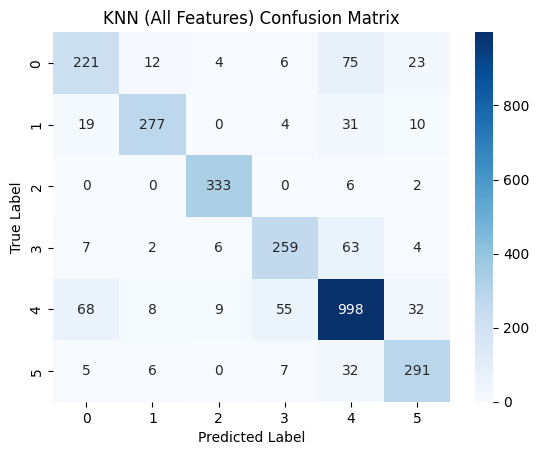

In [13]:
best_accuracy = 0
best_n = 2
for n in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_std, y_train)
    y_pred_knn = knn.predict(X_test_std)
    acc_knn = accuracy_score(y_test, y_pred_knn)
    if acc_knn > best_accuracy:
        best_accuracy = acc_knn
        best_n = n

knn_final = KNeighborsClassifier(n_neighbors=best_n)
knn_final.fit(X_train_std, y_train)
y_pred_knnfinal = knn_final.predict(X_test_std)
acc_knnfinal = accuracy_score(y_test, y_pred_knnfinal)

print(f"\nKNN (All Features) -> Best n_neighbors={best_n}, Accuracy={acc_knnfinal:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_knnfinal))

cf_matrix = confusion_matrix(y_test, y_pred_knnfinal)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title("KNN (All Features) Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### 7.3.2 KNN with LASSO-Selected Features

In [14]:
X_train_lassoKNN = X_train_std[selected_features_lasso]
X_test_lassoKNN  = X_test_std[selected_features_lasso]

best_accuracy_lasso = 0
best_n_lasso = 2
for n in range(1, 21):
    knn_lasso = KNeighborsClassifier(n_neighbors=n)
    knn_lasso.fit(X_train_lassoKNN, y_train)
    y_pred_knn_lasso = knn_lasso.predict(X_test_lassoKNN)
    acc_knn_lasso = accuracy_score(y_test, y_pred_knn_lasso)
    if acc_knn_lasso > best_accuracy_lasso:
        best_accuracy_lasso = acc_knn_lasso
        best_n_lasso = n

print(f"\nKNN (LASSO Features) -> Best n_neighbors={best_n_lasso}, Accuracy={best_accuracy_lasso:.4f}")


KNN (LASSO Features) -> Best n_neighbors=1, Accuracy=0.7510


#### 7.3.3 KNN with RF-Selected Features

In [15]:
X_train_rfKNN = X_train_std[selected_features_rf]
X_test_rfKNN  = X_test_std[selected_features_rf]

best_accuracy_rf = 0
best_n_rf = 2
for n in range(1, 21):
    knn_rf_ = KNeighborsClassifier(n_neighbors=n)
    knn_rf_.fit(X_train_rfKNN, y_train)
    y_pred_knn_rf_ = knn_rf_.predict(X_test_rfKNN)
    acc_knn_rf_ = accuracy_score(y_test, y_pred_knn_rf_)
    if acc_knn_rf_ > best_accuracy_rf:
        best_accuracy_rf = acc_knn_rf_
        best_n_rf = n

print(f"\nKNN (RF Features) -> Best n_neighbors={best_n_rf}, Accuracy={best_accuracy_rf:.4f}")


KNN (RF Features) -> Best n_neighbors=1, Accuracy=0.8275


### 7.4 Example: Hyperparameter Tuning with GridSearchCV

In [16]:
"""
parameter_space = {
    'hidden_layer_sizes': [(5,), (10,), (15,)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.05, 0.1],
    'learning_rate': ['constant', 'adaptive'],
}

mlp_test = MLPClassifier(max_iter=500, random_state=0)
clf = GridSearchCV(mlp_test, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train_std, y_train)

print('Best parameters:\n', clf.best_params_)
print("Best cross-validation score:", clf.best_score_)
"""

'\nparameter_space = {\n    \'hidden_layer_sizes\': [(5,), (10,), (15,)],\n    \'activation\': [\'tanh\', \'relu\'],\n    \'solver\': [\'adam\', \'sgd\'],\n    \'alpha\': [0.0001, 0.05, 0.1],\n    \'learning_rate\': [\'constant\', \'adaptive\'],\n}\n\nmlp_test = MLPClassifier(max_iter=500, random_state=0)\nclf = GridSearchCV(mlp_test, parameter_space, n_jobs=-1, cv=3)\nclf.fit(X_train_std, y_train)\n\nprint(\'Best parameters:\n\', clf.best_params_)\nprint("Best cross-validation score:", clf.best_score_)\n'

### 7.5 SHAP for Interpretability (Optional)

PermutationExplainer explainer: 51it [01:02,  1.44s/it]                        


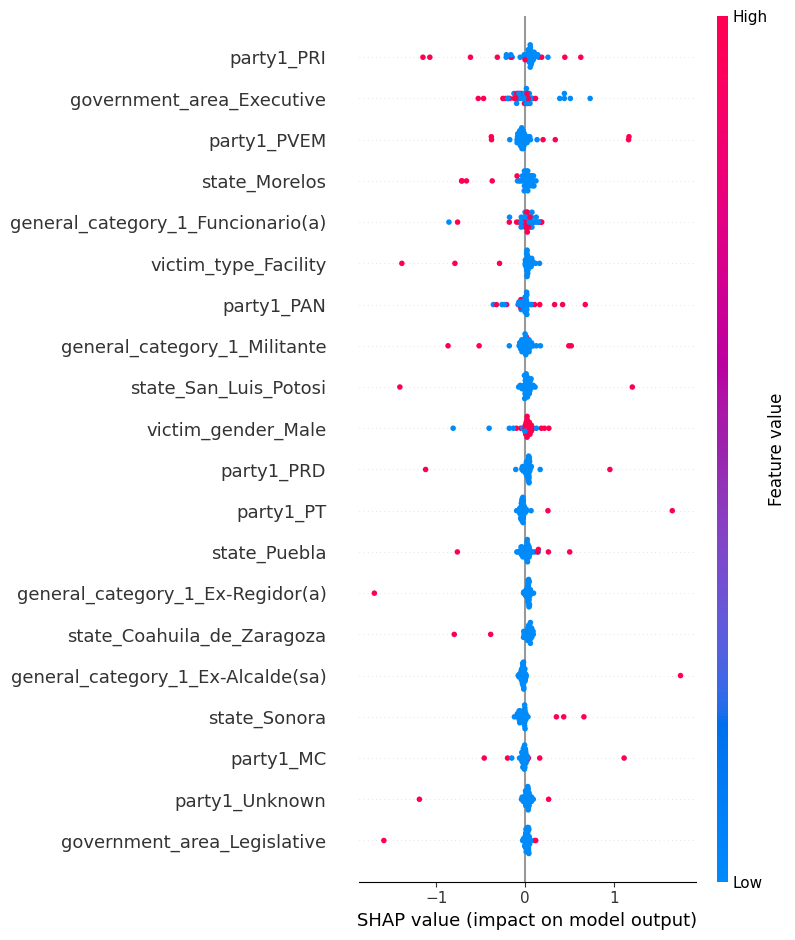

In [17]:
# Example usage of shap on the final KNN model with all features
X_sample = X_test_std.sample(n=50, random_state=0)
explainer = shap.Explainer(knn_final.predict, X_sample)
shap_values = explainer(X_sample)
shap.summary_plot(shap_values, X_sample)

## 8. Prediction on a New Data Row
Below is an example similar to your code for final prediction usage.

In [18]:
Predict1 = pd.DataFrame({
    'Number': [999999],
    'ID': ['GRO-2024-11-17'],
    'event_id': [1000],
    'victim_id': [200],
    'victim_type': ['Authority'],
    'victim_name': ['John Doe'],
    'victim_gender': ['Male'],
    'party1': ['PRD'],
    'party2': [None],
    'party3': [None],
    'party4': [None],
    'coallition': ['No'],
    '1stpoliticaloffice': ['Pre-Candidato del PRI a alcalde de Atoyac'],
    '2ndpoliticaloffice': [None],
    '3rdpoliticaloffice': [None],
    'general_category_1': ['Pre-candidato(a)'],
    'general_category_2': [None],
    'general_category_3': [None],
    'level_of_government': ['Municipal'],
    'government_area': ['Executive'],
    'event_type': [None],
    'aggressor': ['Unknown'],
    'remarks_on_the_crime': ['Details not available'],
    'date': ['2024-01-01'],
    'state': ['Guerrero'],
    'municipal': ['Atoyac de Álvarez'],
    'INEGIcode': ['99999'],
    'MunINEGIcode': ['99999'],
    'Entity': ['ExampleEntity'],
    'Totalpopulation': [1000000],
    'Female_population': [500000],
    'Male_population': [500000],
    'economically_active_population': [600000],
    'No_health_services_pop': [200000],
    '12_year_old_single_population': [150000],
    'ID.1': [123.45],
    'avg_scholarity': [8.5],
    'home_count': [250000],
    'average_number_in_home': [4.0],
    'GDP': [500000.0],
    'Concepto': ['Guerrero']
})

# Duplicate
Predict = Predict1.copy()
Predict = Predict.head(1)

# Same feature transformations:
Predict['Male_population_proportion']   = Predict['Male_population'] / (Predict['Male_population'] + Predict['Female_population'])
Predict['Female_population_proportion'] = Predict['Female_population'] / (Predict['Male_population'] + Predict['Female_population'])
Predict['No_health_proportion']        = Predict['No_health_services_pop'] / (Predict['Male_population'] + Predict['Female_population'])
Predict['12_year_proportion']          = Predict['12_year_old_single_population'] / (Predict['Male_population'] + Predict['Female_population'])

drop_cols_predict = [
    "Totalpopulation","ID.1", "ID", "event_id", "Number", "victim_id", "date",\
    "victim_name", "party2", "party3", "party4", "coallition", "1stpoliticaloffice",\
    "2ndpoliticaloffice", "3rdpoliticaloffice", "general_category_2", "general_category_3",\
    "remarks_on_the_crime", "Concepto", "INEGIcode","MunINEGIcode","aggressor","municipal",\
    "level_of_government", "Male_population", "Female_population", "economically_active_population",\
    "Male_population_proportion","No_health_services_pop","12_year_old_single_population"
]
Predict = Predict.drop(columns=drop_cols_predict, errors='ignore')

# Dummy-encode
string_col = Predict.select_dtypes(include=['object']).columns
Predict_dummy = pd.get_dummies(Predict[string_col], drop_first=True, dtype=int)
Predict = pd.concat([Predict, Predict_dummy], axis=1).drop(columns=string_col, errors='ignore')

# Align features with training
for col in X_train.columns:
    if col not in Predict.columns:
        Predict[col] = 0

Predict = Predict[X_train.columns]
Predict_std = pd.DataFrame(scaler.transform(Predict), columns=Predict.columns)

prediction = knn_final.predict(Predict_std)

# Decode label
decoded_prediction = None
for original_label, encoded_val in label_mapping.items():
    if encoded_val == prediction[0]:
        decoded_prediction = original_label
        break

print(f"\nPREDICTED EVENT TYPE for this new observation: {decoded_prediction}\n")
for col in Predict1.columns:
    if Predict1[col].values[0] is not None:
        print(f"{col}: {Predict1[col].values[0]}")


PREDICTED EVENT TYPE for this new observation: Threat

Number: 999999
ID: GRO-2024-11-17
event_id: 1000
victim_id: 200
victim_type: Authority
victim_name: John Doe
victim_gender: Male
party1: PRD
coallition: No
1stpoliticaloffice: Pre-Candidato del PRI a alcalde de Atoyac
general_category_1: Pre-candidato(a)
level_of_government: Municipal
government_area: Executive
aggressor: Unknown
remarks_on_the_crime: Details not available
date: 2024-01-01
state: Guerrero
municipal: Atoyac de Álvarez
INEGIcode: 99999
MunINEGIcode: 99999
Entity: ExampleEntity
Totalpopulation: 1000000
Female_population: 500000
Male_population: 500000
economically_active_population: 600000
No_health_services_pop: 200000
12_year_old_single_population: 150000
ID.1: 123.45
avg_scholarity: 8.5
home_count: 250000
average_number_in_home: 4.0
GDP: 500000.0
Concepto: Guerrero


C:\Users\Artur\AppData\Local\Temp\ipykernel_13688\1978696347.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Predict[col] = 0
C:\Users\Artur\AppData\Local\Temp\ipykernel_13688\1978696347.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Predict[col] = 0
C:\Users\Artur\AppData\Local\Temp\ipykernel_13688\1978696347.py:73: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

## 9. Cross Validation Examples

In [19]:
print("\n=== Cross Validation (5-fold) for KNN Final ===")
cv_scores = cross_val_score(knn_final, X, y, cv=5, scoring='accuracy')
print("Mean CV Accuracy:", cv_scores.mean(), "Std:", cv_scores.std())

print("\n=== Leave One Out CV ===")
loo = LeaveOneOut()
cv_scores_loocv = cross_val_score(knn_final, X, y, cv=loo, scoring='accuracy')
print("Mean LOOCV accuracy:", cv_scores_loocv.mean())

print("\n=== Stratified K-Fold CV ===")
stratified_kfold = StratifiedKFold(n_splits=5)
cv_scores_stratified = cross_val_score(knn_final, X, y, cv=stratified_kfold, scoring='accuracy')
print("Mean Stratified K-Fold accuracy:", cv_scores_stratified.mean())

# Example GridSearch for KNN
param_grid = {'n_neighbors': list(range(1, 21))}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
print("\n=== GridSearchCV on KNN ===")
print(f"Best params: {grid_search.best_params_}, Best CV Score: {grid_search.best_score_:.4f}")


=== Cross Validation (5-fold) for KNN Final ===
Mean CV Accuracy: 0.586086956521739 Std: 0.02836435900921752

=== Leave One Out CV ===
Mean LOOCV accuracy: 0.5961739130434782

=== Stratified K-Fold CV ===
Mean Stratified K-Fold accuracy: 0.586086956521739

=== GridSearchCV on KNN ===
Best params: {'n_neighbors': 5}, Best CV Score: 0.6136


## End of Notebook 2
We have demonstrated how to build multiple classification models, apply feature selection, and do final predictions.